# Setup

### Initial tasks

In [1]:
# allow multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# suppress warnings
import sys, os, warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# also suppress warnings of parallel processes such as grid search cv
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

### Imports

In [2]:
# built-ins
import os
import json
import math
import time
import pickle
import traceback
from os import path
from pathlib import Path
from datetime import datetime
from itertools import combinations

# common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# misc
from IPython.display import display, clear_output, Markdown
from termcolor import colored

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from scipy.stats import ttest_ind

# training
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### Utils / Helpers

In [3]:
def load_json(path):
    with open(path, encoding='utf-8') as f:
        return json.load(f)
    
def cprint(text, color):
    print(colored(text, color, attrs=['bold']))
    
def print_red(text):
    cprint(text, 'red')

def print_blue(text):
    cprint(text, 'blue')

In [4]:
# Small helper for in-place printing duration of an process.

class PrintDuration(object):
    class printer(str):
        def __repr__(self):
            return self
        
    def __enter__(self):
        self.start_time = datetime.now()
        self.last_tick = self.start_time
        self.tick_count = 0
        self.tick_times = 0
        
        self.completed = False
        self.progress = 0
        self.ert = 0
        self.att = 0
        self.out = None
        
        return self.tick
  
    def __exit__(self, exc_type, exc_value, tb):
        if exc_type is not None:
            traceback.print_exception(exc_type, exc_value, tb)
        
        self.completed = True
        self.render()
        
    def tdformat(self, seconds):
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return '{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds))
    
    def render(self):
        output = ''
        
        if self.completed:
            complete_time = (datetime.now() - self.start_time).total_seconds()
            complete_time = self.tdformat(complete_time)
            output = f'100% completed, total run time = {complete_time}'
        else:
            percent = round(self.progress * 100)
            att = self.tdformat(self.att)
            ert = self.tdformat(self.ert)
            output = f'{percent}% completed, remaining time = {ert}, avg ticktime = {att}'
        
        output = self.printer(output)
        
        if self.out is None:
            self.out = display(output, display_id=True)
        else:
            self.out.update(output)
    
    def tick(self, progress):
        now = datetime.now()
        
        # calculate
        work_time = (now - self.start_time).total_seconds()
        tick_time = (now - self.last_tick).total_seconds()
        self.tick_count += 1
        self.tick_times += tick_time
        avg_tick_time = self.tick_times // self.tick_count
        
        if progress > 0:
            total_ticks = self.tick_count // progress
            remained_ticks = total_ticks - self.tick_count
            est_remain_time = avg_tick_time * remained_ticks
        else:
            est_remain_time = 0
            
        # set
        self.progress = progress
        self.att = avg_tick_time
        self.ert = est_remain_time
        
        # render
        self.render()             

### Detect Env

In [5]:
ENV_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None

### Path Definitions

In [6]:
path_root = '.'
path_dataset = path.join(path_root, 'dataset')
path_csv = path.join(path_dataset, 'csv')
path_csv_output =  path_csv
path_models = path.join(path_root, 'models')

if ENV_KAGGLE:
    path_root = '/kaggle/working'
    path_dataset = '/kaggle/input/aihw2'
    path_csv = path.join(path_dataset, 'csv')
    path_csv_output = path_root
    path_models = path.join(path_root, 'models')
    
# Create directories.
Path(path_models).mkdir(parents=True, exist_ok=True)

### Configs

In [7]:
cfg_autosave_models = False
cfg_force_train = False

if ENV_KAGGLE:
    cfg_autosave_models = True
    cfg_force_train = False

# Hyperparameters

In [8]:
hp_seed = 7908
hp_cv_splits = 10
hp_test_size = 0.2

# Preprocessing

In [9]:
def map_employement_duration(entry):
    entry = str(entry).lower()
    split = entry.split(' ')
    num = split[0]
    output = entry
    
    if "-" in num:
        num = num.split("-")[1]
    
    if "weeks" in entry:
        output = float(num) / 52
    elif ("month" in entry) or ("ay" in entry):
        output = float(num) / 12
    elif ("years" in entry) or ("sene" in entry) or ("yıl" in entry):
        output = float(num)
    else:
        try:
            output = float(num)
        except:
            output = 0
        
    output = round(output, 3)
    return output

In [10]:
# read encodings
encodings = load_json(path.join(path_dataset, 'encodings.json'))

# read csvs
csv_en = pd.read_csv(path.join(path_csv, 'english.csv'), dtype=str, encoding='utf-8')
csv_tr = pd.read_csv(path.join(path_csv, 'turkish.csv'), dtype=str, encoding='utf-8')

# drop columns
csv_en.drop('Timestamp', axis=1, inplace=True)
csv_tr.drop('Timestamp', axis=1, inplace=True)

# rename columns
csv_en.rename(columns=encodings['columns']['en'], inplace=True)
csv_tr.rename(columns=encodings['columns']['tr'], inplace=True)

# encode columns
csv_en.replace(encodings['values']['en'], inplace=True)
csv_tr.replace(encodings['values']['tr'], inplace=True)

# concat csvs
df = pd.concat([csv_en, csv_tr], axis=0).reset_index(drop=True)

# fix NaNs
df.fillna(0, inplace=True)

# convert types
df['age'] = df['age'].apply(lambda x: int(x))
df['weight'] = df['weight'].apply(lambda x: int(float(x.replace(',', '.'))))
df['height'] = df['height'].apply(lambda x: int(x.translate({ord(x): '' for x in [',', '.', ' ']})))
df['employment_duration'] = df['employment_duration'].apply(map_employement_duration)

# save csv
df.to_csv(path.join(path_csv_output, 'data.csv'), index=None, header=True, encoding='utf-8-sig')

# initial feature selection
# drop employment_duration column since it has high correlation with age.
df.drop('employment_duration', axis=1, inplace=True)
df.info()

# separate data and labels
df_data = df.drop('weight', axis=1)
df_labels = df['weight']

# convert to numpy
data = df_data.to_numpy()
labels = df_labels.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       322 non-null    int64
 1   height    322 non-null    int64
 2   weight    322 non-null    int64
 3   gender    322 non-null    int64
 4   smoking   322 non-null    int64
 5   drinking  322 non-null    int64
 6   exercise  322 non-null    int64
 7   married   322 non-null    int64
 8   children  322 non-null    int64
 9   student   322 non-null    int64
 10  employed  322 non-null    int64
dtypes: int64(11)
memory usage: 27.8 KB


In [11]:
df.head()

,age,height,weight,gender,smoking,drinking,exercise,married,children,student,employed
0,36,175,82,1,0,3,1,0,0,0,1
1,22,178,77,1,0,2,1,0,0,1,0
2,32,174,65,1,0,2,1,0,0,1,2
3,21,156,65,0,0,0,2,0,0,1,0
4,24,176,94,1,0,1,1,0,0,1,0


# Pipeline Setup

#### Preprocessor

Preprocessor is responsible for config based column-wise scaling and PCA transformation of given data.

In [12]:
class Preprocessor:
    def __init__(self, scale=False, scale_columns=None, pca=False, pca_n=None):
        self.scale = scale
        self.pca = pca
        
        if self.scale or self.pca:
            self.scale_columns = scale_columns
            self.scaler = preprocessing.StandardScaler()
        
        if self.pca:
            self.pca_n = pca_n
            self.PCA = PCA(n_components=pca_n, svd_solver='full', copy=True)
    
    def fit(self, data):
        if self.pca:
            data = self.scaler.fit_transform(data)
            self.PCA.fit(data)
        elif self.scale:
            cols = self.scale_columns
            self.scaler.fit(data[:, cols])
        
    def transform(self, data):
        if self.pca:
            data = self.scaler.transform(data)
            data = self.PCA.transform(data)
        elif self.scale:
            cols = self.scale_columns
            data[:, cols] = self.scaler.transform(data[:, cols])
            
        return data

#### Model

Model is a wrapper for an individual estimator (such as Linear Regression etc.) and responsible for training single estimator and doing hyperparameter optimization with grid searching.

In [13]:
class Model:
    def __init__(self, estimator, data, labels, n_splits, test_size, seed,
                 prep_params={}, hp_grid=None):
        
        self.estimator = estimator
        self.data = data
        self.labels = labels
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.prep_params = prep_params
        self.hp_grid = hp_grid
        
        self.stats = []
        self.best_stats = None
        self.best_estimator = None
    
    def split(self):
        split = ShuffleSplit(n_splits=self.n_splits, test_size=self.test_size, random_state=self.seed)
        
        for train_index, test_index in split.split(self.data):
            train_data = (self.data[train_index], self.labels[train_index])
            test_data = (self.data[test_index], self.labels[test_index])

            yield(train_data, test_data)
    
    def train(self, tick=None):
        for split_index, (train_data, test_data) in enumerate(self.split()):
            if tick is not None:
                tick(split_index/self.n_splits)
            
            X_train, Y_train = train_data
            X_test, Y_test = test_data
            
            # create and use preprocessor
            preprocessor = Preprocessor(**self.prep_params)
            preprocessor.fit(X_train)
            X_train = preprocessor.transform(X_train)
            X_test = preprocessor.transform(X_test)
            
            estimator = self.estimator()
            
            # default values
            best_params = None
            best_estimator = estimator
            
            # fit estimator
            if self.hp_grid is not None:
                cv = GridSearchCV(estimator, self.hp_grid, cv=self.n_splits, n_jobs=-1)
                cv.fit(X_train, Y_train)
                
                best_params = cv.best_params_
                best_estimator = cv.best_estimator_
            else:
                best_estimator.fit(X_train, Y_train)
            
            Y_pred = best_estimator.predict(X_test)
            rsme = round(np.sqrt(mean_squared_error(Y_test, Y_pred)), 2)
            
            result = dict(y_true=Y_test, y_pred=Y_pred, best_params=best_params, rsme=rsme,
                          seed=self.seed, best_estimator=best_estimator, preprocessor=preprocessor)
            
            self.stats.append(result)
    
    def predict(self, data):
        data = data.copy()
        self.best_preprocessor.transform(data)
        return self.best_estimator.predict(data)
    
    def collect_best_stats(self):
        best_rsme = math.inf
        total_rsme = 0
        best_stats = None
        
        for stats in self.stats:
            rsme = stats['rsme']

            total_rsme += rsme
            if rsme < best_rsme:
                best_rsme = rsme
                best_stats = stats
        
        self.best_stats = best_stats
        self.best_estimator = best_stats['best_estimator']
        self.best_preprocessor = best_stats['preprocessor'] 
        self.mean_rsme = total_rsme / len(self.stats)

#### Trainer

Trainer holds n number of Models and mainly responsible for training them. Also provides functionalities such as saving/loading models to and from the disk, searching best seed in a range for given data and calculating t-test among its models.  

In [14]:
class Trainer:   
    def __init__(self, name, data, labels, n_splits, test_size, seed, prep_params={}):
        self.name = name
        self.data = data
        self.labels = labels
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.prep_params = prep_params
        self.estimators = {}
    
    def set_estimators(self, estimators):
        self.estimators = estimators
    
    def get_model_path(self, name):
        return path.join(path_models, f'{self.name}_{name}.pickle')
    
    def save_model(self, name, model):
        model_path = self.get_model_path(name)
        with open(model_path,'wb') as file:
            pickle.dump(model, file)
        
    def load_model(self, name):
        model_path = self.get_model_path(name)
        with open(model_path, 'rb') as file:
            return pickle.load(file)
        
    def train_estimators(self, **kwargs):
        estimators = kwargs.pop('estimators', self.estimators.keys())
        for name in estimators:
            print_red(f'Estimator: {name}\n')
            model = self.train_estimator(name, **kwargs)
            yield (name, model)
            
    def train_estimator(self, name, reset=False, seed=None, save=True):      
        if seed is None:
            seed = self.seed
        
        if not reset:
            try:
                model = self.load_model(name)
                setattr(self, name, model)
                
                print(f'Model {name} is loaded from disk successfully.')
                return model
            
            except:
                model = None
        
        name, estimator, hp_grid = self.estimators[name]
        model = Model(estimator, self.data, self.labels, self.n_splits,
                    self.test_size, seed, self.prep_params, hp_grid)
        
        with PrintDuration() as tick:
            model.train(tick)

        model.collect_best_stats()
        setattr(self, name, model)
        
        if save:
            self.save_model(name, model)
            
        return model
    
    def search_best_seed(self, name, seed_range=100):
        best_rsme = math.inf
        best_seed = 0

        for seed in range(seed_range):
            estimator = self.train_estimator(name, seed, save=False)
            rsme = estimator.best_stats["rsme"]

            if rsme < best_rsme:
                best_rsme = rsme
                best_seed = seed
                print(f'{seed} -> {rsme} - {estimator.mean_rsme}')
        
        print(f'Best seed found as {best_seed}')
        return best_seed
    
    def calculate_ttest(self, p=0.05):
        models = list(self.estimators.keys())
        scores = {m: [s['rsme'] for s in getattr(self, m).stats] for m in models}
        pairs = list(combinations(models, 2))

        ttests = []
        for a, b in pairs:
            t_val, p_val = ttest_ind(scores[a], scores[b])

            ttests.append({
                'models': [a, b], 't_val': abs(t_val),
                'p_val': p_val, 'significant': p_val <= p
            })

        significants = [t['models'] for t in ttests if t['significant']]
        non_significants = [t['models'] for t in ttests if not t['significant']]

        return significants, non_significants, ttests
    
    def get_results_dataframe(self, name, shuffle=False, ascending=False):
        model = getattr(self, name)

        true = model.best_stats['y_true'].reshape(-1)
        pred = model.best_stats['y_pred'].reshape(-1)
        
        df = pd.DataFrame(data={
            'true': true,
            'prediction': pred,
            'diff': np.absolute(true - pred)
        })
    
        if shuffle:
            df = df.sample(frac=1)
        else:
            df = df.sort_values('diff', ascending=ascending)
        
        return df
    
    def print_stats(self, name):
        model = getattr(self, name)
        print('best_rsme', model.best_stats['rsme'])
        print('mean_rsme', model.mean_rsme)
        print('best_params', model.best_stats['best_params'])

#### SetTrainer

SetTrainer is a thin layer for creating n number of trainers with provided estimators.

In [15]:
class SetTrainer:
    def __init__(self):
        self.estimators = {}
        self.trainer_names = []
        
    def add_estimator(self, name, estimator, hp_grid=None):
        self.estimators[name] = (name, estimator, hp_grid)
        
    def add_trainer(self, **kwargs):
        name = kwargs['name']
        trainer = Trainer(**kwargs)
        trainer.set_estimators(self.estimators)
        
        self.trainer_names.append(name)
        setattr(self, name, trainer)
        
    def run_trainer(self, name, **kwargs):
        trainer = getattr(self, name)
        for (model_name, model) in trainer.train_estimators(**kwargs):
            yield (name, trainer, model_name, model)
            
    def run_all_trainers(self, **kwargs):
        trainers = kwargs.pop('trainers', self.trainer_names)
        count = len(trainers)
        
        for index, name in enumerate(trainers):
            print_blue(f'Trainer {index+1}/{count}: {name}\n')
            for (trainer_name, trainer, model_name, model) in self.run_trainer(name, **kwargs):
                yield (trainer_name, trainer, model_name, model)
    
    def plot_rsme_scores(self, save=True):
        values = []

        # collect scores.
        for trainer_name in self.trainer_names:
            trainer = getattr(self, trainer_name)

            for model_name in trainer.estimators:
                model = getattr(trainer, model_name)
                rsme = round(model.best_stats['rsme'], 1)

                values.append([trainer_name, model_name, rsme])

        df = pd.DataFrame(values, columns=['group','column','val'])

        # plot
        plt.figure()
        plt.rcParams.update({'font.size': 13})
        ax = df.pivot("column", "group", "val").plot(kind='bar', figsize=(20, 7), width=0.9)

        # add bar annotations.
        for p in ax.patches:
            ax.annotate(
                np.round(p.get_height(), decimals=2), (p.get_x()+p.get_width()/2., p.get_height()),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        # Add top margin.
        x0, x1, y0, y1 = plt.axis()
        plt.axis((x0, x1, y0, y1 + 1))

        # Save figure.
        if save:
            plt.savefig('figures/model_results.png')
    
set_trainer = SetTrainer()

### Helper Functions

### Feature Importance

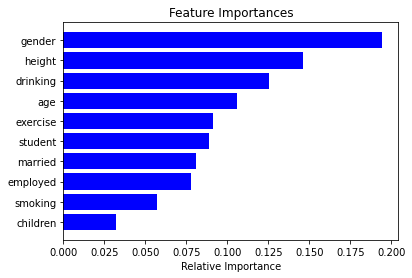

In [16]:
def calculate_feature_importances(data, labels, n_splits, test_size, seed, prep_params={}):
    model = Model(RandomForestRegressor, data, labels, n_splits, test_size, seed, prep_params)
    model.train()
    model.collect_best_stats()
    
    importances = model.best_estimator.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [df_data.columns.to_list()[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
calculate_feature_importances(data=data, labels=labels, n_splits=hp_cv_splits,
                              test_size=hp_test_size, seed=hp_seed,
                              prep_params={'scale':True, 'scale_columns':[0, 1]})

### Explained Variance Ratio

For p=99% n_components should be 10



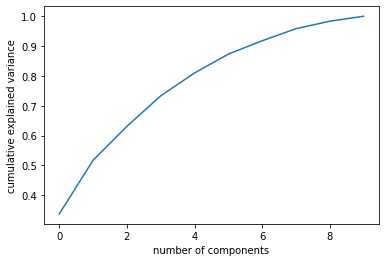

In [17]:
def calculate_explained_variance_ratio(data, p=0.95):
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(data)
    
    pca = PCA(n_components=None, svd_solver='full', copy=True)
    reduced = pca.fit_transform(X)
    
    # extract the smallest number of components which
    # explain at least p% (e.g. 80%) of the variance
    n_components = 1 + np.argmax(np.cumsum(pca.explained_variance_ratio_) >= p)
    print(f'For p={int(p*100)}% n_components should be {n_components}\n')

    # extract the values of the selected components
    #Z = pca.transform(X)[:, :n_components]
    
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    
calculate_explained_variance_ratio(data, 0.99)

# Model Definitions

## Linear Regression 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [18]:
# Add estimator
set_trainer.add_estimator('linear', LinearRegression, {
    'fit_intercept': [True, False],
    'positive': [False, True], 
})

## Support Vector Regression

[docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [19]:
# Add estimator
set_trainer.add_estimator('svr', SVR, {
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'C': [1, 10, 100],
    'epsilon': [0.05, 0.1, 0.2]
})

## Bayesian Ridge

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html)

In [20]:
# Add estimator
set_trainer.add_estimator('br', BayesianRidge, {
    'n_iter': [300, 500, 700]
})

## kNN

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

In [21]:
# Add estimator
set_trainer.add_estimator('knn', KNeighborsRegressor, {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
})

## Decision Tree

[docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [22]:
# Add estimator
set_trainer.add_estimator('dt', DecisionTreeRegressor, {
    'criterion': ['squared_error', 'absolute_error'],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [1, 0.8, 0.5],
})

## Bagging

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html)

In [23]:
# Add estimator
set_trainer.add_estimator('bag', BaggingRegressor, {
    'n_estimators': [10, 20, 50],
    'max_samples': [1, 0.8, 0.5],
    'max_features': [1, 0.8, 0.5],
})

## Random Forest

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [24]:
# Add estimator
set_trainer.add_estimator('rf', RandomForestRegressor, {
    'n_estimators': [100, 200, 500],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2],
    'max_features': [1, 0.8, 0.5],
    'max_samples': [1, 0.8, 0.5],
})

## XGBoost

[doc](https://xgboost.readthedocs.io/en/stable/parameter.html)

In [25]:
# Add estimator
set_trainer.add_estimator('xgb', XGBRegressor, {
    'learning_rate': [0.1, 0.3, 0.5],
    'subsample': [0.5, 0.75, 1],
})

## AdaBoost

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)

In [26]:
# Add estimator
set_trainer.add_estimator('ada', AdaBoostClassifier, {
    'learning_rate': [0.3, 0.5, 1],
    'n_estimators': [50, 100, 200],
})

## LGBM

[doc](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [27]:
# Add estimator
set_trainer.add_estimator('lgbm', LGBMRegressor, {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
})

## MLP

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

In [28]:
# Add estimator
set_trainer.add_estimator('mlp', MLPRegressor, {
    'hidden_layer_sizes': [(100,), (128,128), (256,)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'batch_size': ['auto', 16, 32],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.003, 0.01],
    'early_stopping': [True],
})

# Training

### Transformation Helper

In [29]:
def transform_dataset(data, scale_cols=[], drop_cols=[]):
    rest_col_names = list(pd.Index([col for i, col in enumerate(df_data.columns) if i not in drop_cols])[scale_cols])
    drop_col_names = list(df_data.columns[drop_cols])
    
    if len(drop_cols) > 0:
        print(f'Features that will be dropped: {drop_col_names}')
        data = np.delete(data, drop_cols, axis=1)
        
    if len(scale_cols) > 0:
        print(f'Features that will be scaled: {rest_col_names}')
        
    return data

## Trainer Definitions

### Default Trainer

In [30]:
# Print scale information.
scale_cols = [0, 1] # Scale only numeric features.
_ = transform_dataset(data, scale_cols)

# Preprocessor params.
prep_params = {'scale': True, 'scale_columns': scale_cols, 'pca': False}

# Add trainer.
set_trainer.add_trainer(name='default', data=data, labels=labels, n_splits=hp_cv_splits,
                        test_size=hp_test_size, seed=hp_seed, prep_params=prep_params)

Features that will be scaled: ['age', 'height']


### Feature Selected Trainer

In [31]:
# Print scale & drop information
drop_cols = [7]
scale_cols = [0, 1] # Scale only numeric features.
fselected_data = transform_dataset(data, scale_cols, drop_cols)

# Preprocessor params.
prep_params = {'scale': True, 'scale_columns': scale_cols, 'pca': False}

# Add trainer.
set_trainer.add_trainer(name='fselected', data=fselected_data, labels=labels, n_splits=hp_cv_splits,
                        test_size=hp_test_size, seed=hp_seed, prep_params=prep_params)

Features that will be dropped: ['children']
Features that will be scaled: ['age', 'height']


### PCA Trainer

In [32]:
# Preprocessor params.
prep_params = {'pca': True, 'pca_n': 0.99} # All features will be scaled and transformed via PCA.

# Add trainer.
set_trainer.add_trainer(name='pca', data=data, labels=labels, n_splits=hp_cv_splits,
                        test_size=hp_test_size, seed=hp_seed, prep_params=prep_params)

### Training

In [33]:
options = {
    # set trainer parameters
    #'trainers': [],
    
    # trainer parameters
    #'estimators': [],
    #'reset': False,
    #'seed': None,
    #'save': False,
}

for (trainer_name, trainer, model_name, model) in set_trainer.run_all_trainers(**options):
    # Show stats.
    print()
    trainer.print_stats(model_name)
    print()
    
    # Show predicts.
    trainer.get_results_dataframe(model_name, ascending=True).head()

Trainer 1/3: default

Estimator: linear

Model linear is loaded from disk successfully.

best_rsme 7.7
mean_rsme 11.59
best_params {'fit_intercept': True, 'positive': True}



,true,prediction,diff
18,82,82.155117,0.155117
13,72,71.790341,0.209659
14,71,71.790341,0.790341
9,62,61.209140,0.790860
2,62,60.533162,1.466838


Estimator: svr

Model svr is loaded from disk successfully.

best_rsme 8.47
mean_rsme 11.814999999999998
best_params {'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'linear'}



,true,prediction,diff
31,68,67.996834,0.003166
58,70,70.075950,0.075950
54,73,72.664950,0.335050
56,70,70.492867,0.492867
35,77,77.580306,0.580306


Estimator: br

Model br is loaded from disk successfully.

best_rsme 7.7
mean_rsme 11.528999999999998
best_params {'n_iter': 300}



,true,prediction,diff
2,62,62.094818,0.094818
58,70,70.294600,0.294600
3,85,85.323616,0.323616
53,82,82.405332,0.405332
6,76,76.430206,0.430206


Estimator: knn

Model knn is loaded from disk successfully.

best_rsme 9.06
mean_rsme 12.482
best_params {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}



,true,prediction,diff
27,59,59.000000,0.000000
55,63,63.285714,0.285714
22,67,66.571429,0.428571
37,83,83.857143,0.857143
6,76,75.000000,1.000000


Estimator: dt

Model dt is loaded from disk successfully.

best_rsme 9.53
mean_rsme 13.492
best_params {'criterion': 'squared_error', 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 2}



,true,prediction,diff
40,83,83.00,0.00
45,83,83.00,0.00
28,70,69.84,0.16
55,63,62.80,0.20
59,69,69.84,0.84


Estimator: bag

Model bag is loaded from disk successfully.

best_rsme 8.53
mean_rsme 11.968000000000002
best_params {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 50}



,true,prediction,diff
61,64,63.943658,0.056342
28,70,70.124614,0.124614
56,70,69.509528,0.490472
29,60,59.449500,0.550500
53,82,81.424167,0.575833


Estimator: rf

Model rf is loaded from disk successfully.

best_rsme 7.75
mean_rsme 11.841000000000001
best_params {'max_features': 0.5, 'max_samples': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}



,true,prediction,diff
42,82,82.116623,0.116623
27,59,58.774132,0.225868
28,70,70.293499,0.293499
53,82,81.509116,0.490884
13,72,71.328825,0.671175


Estimator: xgb

Model xgb is loaded from disk successfully.

best_rsme 9.78
mean_rsme 13.222
best_params {'learning_rate': 0.1, 'subsample': 0.75}



,true,prediction,diff
51,75,75.154953,0.154953
14,71,70.712921,0.287079
40,83,83.613197,0.613197
28,70,70.712921,0.712921
55,63,62.118923,0.881077


Estimator: ada

Model ada is loaded from disk successfully.

best_rsme 12.53
mean_rsme 15.018000000000004
best_params {'learning_rate': 1, 'n_estimators': 200}



,true,prediction,diff
25,65,65,0
55,63,63,0
17,64,63,1
47,66,65,1
2,62,63,1


Estimator: lgbm

Model lgbm is loaded from disk successfully.

best_rsme 7.59
mean_rsme 11.831
best_params {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'n_estimators': 100, 'subsample': 0.5}



,true,prediction,diff
27,59,58.955529,0.044471
2,62,61.655143,0.344857
28,70,69.636915,0.363085
4,65,64.513540,0.486460
3,85,84.450377,0.549623


Estimator: mlp

Model mlp is loaded from disk successfully.

best_rsme 8.4
mean_rsme 12.192000000000002
best_params {'activation': 'relu', 'batch_size': 16, 'early_stopping': True, 'hidden_layer_sizes': (256,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'solver': 'sgd'}



,true,prediction,diff
29,60,60.005633,0.005633
2,62,61.986196,0.013804
1,53,53.018253,0.018253
58,70,70.028398,0.028398
3,85,85.206937,0.206937


Trainer 2/3: fselected

Estimator: linear

Model linear is loaded from disk successfully.

best_rsme 7.7
mean_rsme 11.56
best_params {'fit_intercept': True, 'positive': True}



,true,prediction,diff
18,82,82.155117,0.155117
13,72,71.790341,0.209659
14,71,71.790341,0.790341
9,62,61.209140,0.790860
2,62,60.533162,1.466838


Estimator: svr

Model svr is loaded from disk successfully.

best_rsme 8.12
mean_rsme 11.794999999999998
best_params {'C': 10, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}



,true,prediction,diff
13,72,71.794401,0.205599
14,71,70.612564,0.387436
6,76,76.438903,0.438903
27,59,58.541299,0.458701
3,85,84.414079,0.585921


Estimator: br

Model br is loaded from disk successfully.

best_rsme 7.81
mean_rsme 11.559999999999999
best_params {'n_iter': 300}



,true,prediction,diff
2,62,62.053685,0.053685
6,76,76.218528,0.218528
58,70,70.342281,0.342281
29,60,59.620946,0.379054
56,70,70.513366,0.513366


Estimator: knn

Model knn is loaded from disk successfully.

best_rsme 8.88
mean_rsme 12.517
best_params {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}



,true,prediction,diff
27,59,59.000000,0.000000
55,63,63.285714,0.285714
22,67,66.571429,0.428571
37,83,83.857143,0.857143
6,76,75.000000,1.000000


Estimator: dt

Model dt is loaded from disk successfully.

best_rsme 10.34
mean_rsme 13.679999999999998
best_params {'criterion': 'squared_error', 'max_features': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 2}



,true,prediction,diff
28,70,69.840000,0.160000
1,53,53.333333,0.333333
42,82,81.250000,0.750000
59,69,69.840000,0.840000
51,75,76.000000,1.000000


Estimator: bag

Model bag is loaded from disk successfully.

best_rsme 8.56
mean_rsme 11.926000000000002
best_params {'max_features': 0.5, 'max_samples': 0.8, 'n_estimators': 50}



,true,prediction,diff
56,70,69.999150,0.000850
35,77,76.807228,0.192772
61,64,63.805077,0.194923
30,75,75.211438,0.211438
14,71,70.628724,0.371276


Estimator: rf

Model rf is loaded from disk successfully.

best_rsme 7.63
mean_rsme 11.736999999999998
best_params {'max_features': 0.5, 'max_samples': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}



,true,prediction,diff
9,62,61.829092,0.170908
13,72,72.228493,0.228493
14,71,70.524430,0.475570
28,70,70.524430,0.524430
27,59,59.696157,0.696157


Estimator: xgb

Model xgb is loaded from disk successfully.

best_rsme 9.46
mean_rsme 13.272
best_params {'learning_rate': 0.1, 'subsample': 0.5}



,true,prediction,diff
14,71,71.402870,0.402870
9,62,61.101505,0.898495
4,65,65.977386,0.977386
27,59,57.718872,1.281128
3,85,86.292656,1.292656


Estimator: ada

Model ada is loaded from disk successfully.

best_rsme 12.59
mean_rsme 15.333000000000002
best_params {'learning_rate': 0.5, 'n_estimators': 50}



,true,prediction,diff
16,65,65,0
58,65,65,0
54,65,65,0
47,65,65,0
1,61,60,1


Estimator: lgbm

Model lgbm is loaded from disk successfully.

best_rsme 7.56
mean_rsme 11.818999999999999
best_params {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'n_estimators': 100, 'subsample': 0.5}



,true,prediction,diff
13,72,71.873343,0.126657
28,70,70.176085,0.176085
18,82,82.197109,0.197109
3,85,85.332932,0.332932
4,65,65.522942,0.522942


Estimator: mlp

Model mlp is loaded from disk successfully.

best_rsme 7.88
mean_rsme 11.924000000000001
best_params {'activation': 'relu', 'batch_size': 16, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'solver': 'sgd'}



,true,prediction,diff
14,71,70.949024,0.050976
56,70,69.683430,0.316570
55,63,62.607565,0.392435
6,76,75.449659,0.550341
58,70,70.644862,0.644862


Trainer 3/3: pca

Estimator: linear

Model linear is loaded from disk successfully.

best_rsme 6.58
mean_rsme 11.265
best_params {'fit_intercept': True, 'positive': False}



,true,prediction,diff
42,82,81.991785,0.008215
50,66,66.264973,0.264973
10,90,90.379663,0.379663
23,51,51.627927,0.627927
27,59,58.343473,0.656527


Estimator: svr

Model svr is loaded from disk successfully.

best_rsme 7.7
mean_rsme 11.535999999999998
best_params {'C': 1, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}



,true,prediction,diff
14,71,71.026759,0.026759
48,70,69.877046,0.122954
0,74,73.821067,0.178933
19,55,55.484214,0.484214
53,82,82.584855,0.584855


Estimator: br

Model br is loaded from disk successfully.

best_rsme 6.7
mean_rsme 11.176
best_params {'n_iter': 300}



,true,prediction,diff
27,59,58.714554,0.285446
58,70,69.501850,0.498150
42,82,82.774539,0.774539
50,66,66.859871,0.859871
18,82,80.843548,1.156452


Estimator: knn

Model knn is loaded from disk successfully.

best_rsme 8.84
mean_rsme 12.254
best_params {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}



,true,prediction,diff
55,63,62.857143,0.142857
6,76,76.285714,0.285714
3,85,84.428571,0.571429
19,55,55.857143,0.857143
0,74,73.000000,1.000000


Estimator: dt

Model dt is loaded from disk successfully.

best_rsme 10.73
mean_rsme 15.575
best_params {'criterion': 'absolute_error', 'max_features': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 8}



,true,prediction,diff
4,65,65.0,0.0
0,74,75.0,1.0
56,70,71.0,1.0
37,83,82.0,1.0
19,55,56.0,1.0


Estimator: bag

Model bag is loaded from disk successfully.

best_rsme 8.12
mean_rsme 11.972
best_params {'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 50}



,true,prediction,diff
61,64,64.00,0.00
15,71,71.04,0.04
24,58,57.92,0.08
27,59,59.18,0.18
0,74,74.36,0.36


Estimator: rf

Model rf is loaded from disk successfully.

best_rsme 7.07
mean_rsme 11.304000000000002
best_params {'max_features': 0.5, 'max_samples': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 500}



,true,prediction,diff
32,77,77.111789,0.111789
27,59,59.115382,0.115382
3,85,84.869900,0.130100
61,64,64.241378,0.241378
16,86,85.457905,0.542095


Estimator: xgb

Model xgb is loaded from disk successfully.

best_rsme 9.21
mean_rsme 12.523
best_params {'learning_rate': 0.1, 'subsample': 0.75}



,true,prediction,diff
5,87,86.889862,0.110138
15,71,71.183426,0.183426
45,83,83.244972,0.244972
51,75,74.754845,0.245155
6,76,75.535675,0.464325


Estimator: ada

Model ada is loaded from disk successfully.

best_rsme 10.89
mean_rsme 14.2
best_params {'learning_rate': 0.3, 'n_estimators': 50}



,true,prediction,diff
38,75,75,0
11,58,58,0
49,74,75,1
10,70,71,1
37,68,69,1


Estimator: lgbm

Model lgbm is loaded from disk successfully.

best_rsme 6.92
mean_rsme 11.668
best_params {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'n_estimators': 100, 'subsample': 0.5}



,true,prediction,diff
1,53,53.063007,0.063007
3,85,85.079067,0.079067
15,71,71.106681,0.106681
45,83,82.885501,0.114499
12,69,69.115760,0.115760


Estimator: mlp

Model mlp is loaded from disk successfully.

best_rsme 8.2
mean_rsme 11.953999999999999
best_params {'activation': 'relu', 'batch_size': 32, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'sgd'}



,true,prediction,diff
50,66,65.250332,0.749668
39,50,49.229354,0.770646
8,82,82.843097,0.843097
18,82,83.157596,1.157596
15,71,69.793814,1.206186


### Scores

<Figure size 432x288 with 0 Axes>

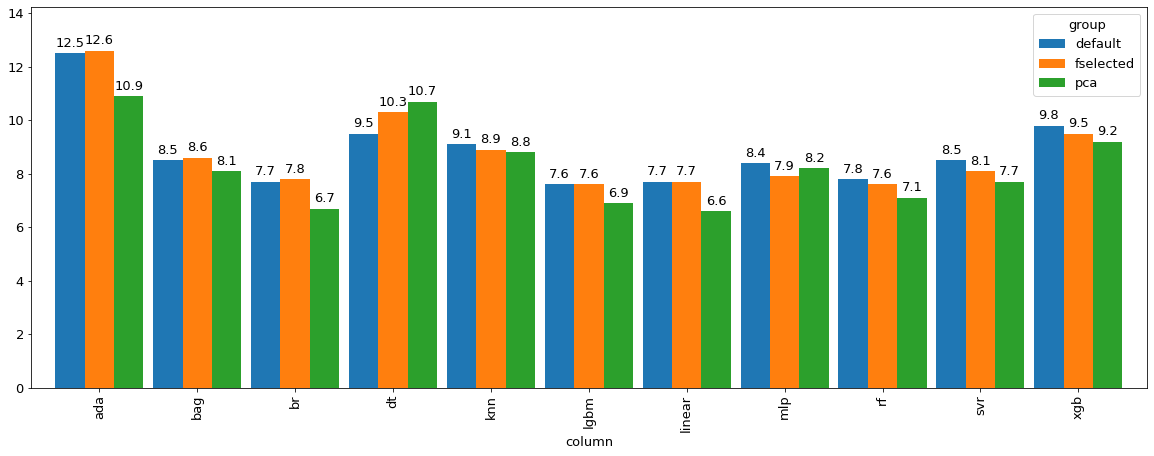

In [34]:
set_trainer.plot_rsme_scores()

# T-Tests

In [35]:
significants, non_significants, ttests = set_trainer.default.calculate_ttest()
significants

[['linear', 'ada'],
 ['svr', 'ada'],
 ['br', 'ada'],
 ['knn', 'ada'],
 ['bag', 'ada'],
 ['rf', 'ada'],
 ['xgb', 'ada'],
 ['ada', 'lgbm'],
 ['ada', 'mlp']]

In [36]:
significants, non_significants, ttests = set_trainer.fselected.calculate_ttest()
significants

[['linear', 'dt'],
 ['linear', 'ada'],
 ['svr', 'ada'],
 ['br', 'dt'],
 ['br', 'ada'],
 ['knn', 'ada'],
 ['bag', 'ada'],
 ['rf', 'ada'],
 ['xgb', 'ada'],
 ['ada', 'lgbm'],
 ['ada', 'mlp']]

In [37]:
significants, non_significants, ttests = set_trainer.pca.calculate_ttest()
significants

[['linear', 'dt'],
 ['linear', 'ada'],
 ['svr', 'dt'],
 ['svr', 'ada'],
 ['br', 'dt'],
 ['br', 'ada'],
 ['knn', 'dt'],
 ['dt', 'bag'],
 ['dt', 'rf'],
 ['dt', 'xgb'],
 ['dt', 'lgbm'],
 ['dt', 'mlp'],
 ['bag', 'ada'],
 ['rf', 'ada'],
 ['ada', 'lgbm'],
 ['ada', 'mlp']]